In [1]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import src.data.preprocessor2 as pre
import src.data.datasets2 as data
from src.model.network import create_model, quantile_loss, create_MQDCNN, MultiQuantileLoss
from src.utils import compute_coverage_len, plot_quantiles, compute_quantile, compute_quantiles_nex

In [3]:
import os
#in order not to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [4]:
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
ignore_columns = ["time", "os1", "os2", "os3"]
exp = '3'
dataset = data.get_dataset("CMAPSS"+exp, MinMaxScaler(feature_range=(-1, 1)))
split_dataset = pre.split_dataset(dataset, calval_size=0.15, random_state=0)
proc_dataset = pre.preprocess_split(split_dataset, scaler_factory=dataset["scaler_factory"], window_size=dataset["window_size"], removable_cols=removable_cols, ignore_columns=ignore_columns)

In [5]:
np.unique(split_dataset["train"]["id"])

array([  1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  13,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        75,  77,  78,  80,  81,  82,  83,  84,  85,  86,  88,  89,  90,
        91,  92,  95,  97,  98,  99, 100], dtype=int64)

In [6]:
np.unique(split_dataset["calval"]["id"])

array([ 3,  8, 14, 17, 27, 54, 55, 56, 74, 76, 79, 87, 93, 94, 96],
      dtype=int64)

In [7]:
np.unique(proc_dataset["train"]["id"])

array([  1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  13,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        75,  77,  78,  80,  81,  82,  83,  84,  85,  86,  88,  89,  90,
        91,  92,  95,  97,  98,  99, 100], dtype=int64)

In [8]:
np.unique(proc_dataset["calval"]["id"])

array([ 3,  8, 14, 17, 27, 54, 55, 56, 74, 76, 79, 87, 93, 94, 96],
      dtype=int64)

In [9]:
proc_dataset["train"]["X"].shape

(18275, 30, 14, 1)

In [10]:
proc_dataset["calval"]["X"].shape

(3545, 30, 14, 1)

In [11]:
proc_dataset["train"]["X"].shape[0] + proc_dataset["calval"]["X"].shape[0]

21820

# train an ordinary mean estimator for SCP and nex-SCP

In [12]:
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer

X_train = proc_dataset["train"]["X"]
y_train = proc_dataset["train"]["y"]
DCNN = create_model(window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
36/36 [==============================] - 6s 148ms/step - loss: 7668.4634 - root_mean_squared_error: 87.5698
Epoch 2/100
36/36 [==============================] - 6s 158ms/step - loss: 6710.2441 - root_mean_squared_error: 81.9161
Epoch 3/100
36/36 [==============================] - 6s 169ms/step - loss: 6189.3574 - root_mean_squared_error: 78.6725
Epoch 4/100
36/36 [==============================] - 6s 181ms/step - loss: 5716.8228 - root_mean_squared_error: 75.6097
Epoch 5/100
36/36 [==============================] - 6s 168ms/step - loss: 5283.2603 - root_mean_squared_error: 72.6860
Epoch 6/100
36/36 [==============================] - 6s 178ms/step - loss: 4882.5825 - root_mean_squared_error: 69.8755
Epoch 7/100
36/36 [==============================] - 6s 170ms/step - loss: 4510.8188 - root_mean_squared_error: 67.1626
Epoch 8/100
36/36 [==============================] - 6s 167ms/step - loss: 4166.8770 - root_mean_squared_error: 64.5514
Epoch 9/100
36/36 [=====================

# train a quantile estimator for CQR

In [13]:
alpha = 0.4
epochs = 100
quantiles = [alpha/2, 1 - alpha/2]
loss_func = MultiQuantileLoss(quantiles=quantiles)

MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
36/36 [==============================] - 7s 185ms/step - loss: 72.0766 - q0_loss: 16.1331 - q1_loss: 55.9435 - q0_root_mean_squared_error: 89.6892 - q1_root_mean_squared_error: 80.4227
Epoch 2/100
36/36 [==============================] - 7s 188ms/step - loss: 55.8940 - q0_loss: 13.1748 - q1_loss: 42.7192 - q0_root_mean_squared_error: 74.2886 - q1_root_mean_squared_error: 63.8062
Epoch 3/100
36/36 [==============================] - 7s 190ms/step - loss: 45.6014 - q0_loss: 11.0702 - q1_loss: 34.5312 - q0_root_mean_squared_error: 63.5949 - q1_root_mean_squared_error: 53.0525
Epoch 4/100
36/36 [==============================] - 7s 187ms/step - loss: 38.1910 - q0_loss: 9.5931 - q1_loss: 28.5979 - q0_root_mean_squared_error: 55.3585 - q1_root_mean_squared_error: 44.9792
Epoch 5/100
36/36 [==============================] - 7s 188ms/step - loss: 32.4923 - q0_loss: 8.5167 - q1_loss: 23.9756 - q0_root_mean_squared_error: 48.8316 - q1_root_mean_squared_error: 38.4639
Epoch 6/100
36/36

# Checking whether calibration works fine

In [18]:
R = 50
rho = 0.99
alpha = 0.1
SCP = [] #Split conformal prediction
nex_SCP = [] #non-exchangeable Split conformal prediction
CQR = [] #conformalized quantile regression


for r in range(R):
    val_idx, cal_idx = pre.split_by_group(X=proc_dataset["calval"]["X"], groups=proc_dataset["calval"]["id"], n_splits=1, test_size=0.5, random_state=r)
    X_val, X_cal = proc_dataset["calval"]["X"][val_idx], proc_dataset["calval"]["X"][cal_idx]
    y_val, y_cal = proc_dataset["calval"]["y"][val_idx], proc_dataset["calval"]["y"][cal_idx]
    idx_val, idx_cal = proc_dataset["calval"]["index"][val_idx], proc_dataset["calval"]["index"][cal_idx]
    id_val, id_cal = proc_dataset["calval"]["id"][val_idx], proc_dataset["calval"]["id"][cal_idx]

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_val = DCNN.predict(x=X_val, verbose=0)
    scores = np.abs(y_cal - y_hat_cal) 
    q = compute_quantile(scores, alpha)
    q_array = compute_quantiles_nex(rho, scores, idx_val, idx_cal, alpha)
    SCP.append(compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q))
    nex_SCP.append(compute_coverage_len(y_val, y_hat_val-q_array, y_hat_val+q_array))

    y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
    y_hat_val_CQR = MQDCNN.predict(x=X_val, verbose=0)
    scores_low = y_hat_cal_CQR[0] - y_cal
    scores_high = y_cal - y_hat_cal_CQR[1] 
    scores_CQR = np.maximum(scores_low, scores_high)
    q_CQR = compute_quantile(scores_CQR, alpha)
    CQR.append(compute_coverage_len(y_val, y_hat_val_CQR[0] - q_CQR, y_hat_val_CQR[1] + q_CQR))
    


left_coverage_nex_SCP, coverage_nex_SCP, avg_length_nex_SCP =  zip(*nex_SCP)
left_coverage_SCP, coverage_SCP, avg_length_SCP =  zip(*SCP)
left_coverage_CQR, coverage_CQR, avg_length_CQR =  zip(*CQR)

(array([ 1.,  1.,  3.,  2.,  8., 10., 13.,  4.,  6.,  2.]),
 array([25.40931 , 26.440165, 27.47102 , 28.501875, 29.53273 , 30.563585,
        31.59444 , 32.625298, 33.65615 , 34.687004, 35.71786 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

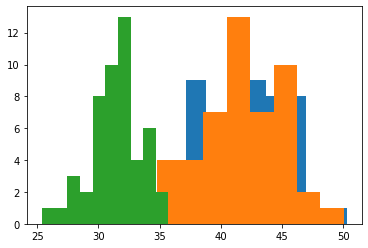

In [19]:
plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)

In [20]:
print(f"SCP: {np.mean(avg_length_SCP)}, nex-SCP: {np.mean(avg_length_nex_SCP)}, CQR: {np.mean(avg_length_CQR)} ")

SCP: 41.720252990722656, nex-SCP: 41.434024810791016, CQR: 31.383874893188477 


(array([ 1.,  2.,  1.,  5.,  3.,  9., 12., 11.,  4.,  2.]),
 array([0.8213892 , 0.8354076 , 0.849426  , 0.86344441, 0.87746281,
        0.89148122, 0.90549962, 0.91951802, 0.93353643, 0.94755483,
        0.96157324]),
 <BarContainer object of 10 artists>)

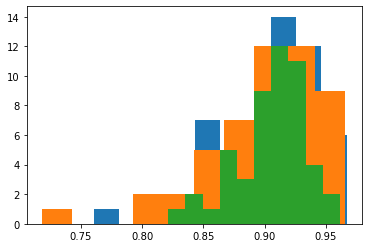

In [21]:
plt.hist(coverage_SCP)
plt.hist(coverage_nex_SCP)
plt.hist(coverage_CQR)

In [22]:
print(f"SCP: {np.mean(coverage_SCP)}, nex-SCP: {np.mean(coverage_nex_SCP)}, CQR: {np.mean(coverage_CQR)} ")

SCP: 0.9014602342707579, nex-SCP: 0.9022295458742211, CQR: 0.9049742942893911 


In [23]:
X_test, y_test, idx_test = [], [], []
for id in np.unique(proc_dataset["test"]["id"]):
    X_test.append(proc_dataset["test"]["X"][proc_dataset["test"]["id"]==id][-1])
    y_test.append(proc_dataset["test"]["y"][proc_dataset["test"]["id"]==id][-1])
    idx_test.append(proc_dataset["test"]["index"][proc_dataset["test"]["id"]==id][-1])

In [24]:
X_test = np.array(X_test)
y_test = np.array(y_test)
idx_test = np.array(idx_test)

In [25]:
X_test.shape

(100, 30, 14, 1)

# Now calibrate using calval data and test it on test  

In [30]:
alpha = 0.1

X_cal, y_cal, idx_cal = proc_dataset["calval"]["X"], proc_dataset["calval"]["y"], proc_dataset["calval"]["index"]
y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
y_hat_test = DCNN.predict(x=X_test, verbose=0)
scores = np.abs(y_cal - y_hat_cal) 
q = compute_quantile(scores, alpha)
q_array = compute_quantiles_nex(rho, scores, idx_test, idx_cal, alpha)


print(compute_coverage_len(y_test, y_hat_test - q, y_hat_test + q))
print(compute_coverage_len(y_test, y_hat_test  - q_array, y_hat_test  + q_array))

y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
y_hat_test_CQR = MQDCNN.predict(x=X_test, verbose=0)
scores_low = y_hat_cal_CQR[0] - y_cal
scores_high = y_cal - y_hat_cal_CQR[1] 
scores_CQR = np.maximum(scores_low, scores_high)
q_CQR = compute_quantile(scores_CQR, alpha)

print(compute_coverage_len(y_test, y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR))

(0.9, 0.88, 41.198154)
(0.91, 0.89, 40.954502)
(0.87, 0.84, 33.024723)


In [27]:
from cProfile import label
import matplotlib

def plot_sorted(exp_num, methods, y_true):
    
    sorted_y_idx = y_true.argsort(axis=0)
    sorted_y = y_true[sorted_y_idx.reshape(-1)]
    fig = plt.figure(figsize=(40, 10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 35
    i = 1
    colors = ["blue", "red", "green"]
    for m in methods:
        lower = methods[m][0]
        upper = methods[m][1]
        sorted_low = np.maximum(0,lower[sorted_y_idx])
        sorted_up = upper[sorted_y_idx]
        ax = fig.add_subplot(1,3,i)
        ax.fill_between(range(len(sorted_y)), sorted_low.reshape(-1), sorted_up.reshape(-1), color=colors[i-1], alpha=0.1, label=m)
        ax.plot(range(len(sorted_y)), sorted_y, 'ok', label="True labels", alpha=0.4)
        plt.ylim([0,180])
        plt.xlabel('Test units with increasing RUL')
        plt.legend(loc='lower right')
        i = i + 1
    plt.savefig('result_figs\\'+str(exp_num)+'.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [28]:
methods = {"SCP" : (y_hat_test - q, y_hat_test + q),
           "nex-SCP" : (y_hat_test  - q_array, y_hat_test  + q_array), 
           "CQR" : (y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR)
           }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


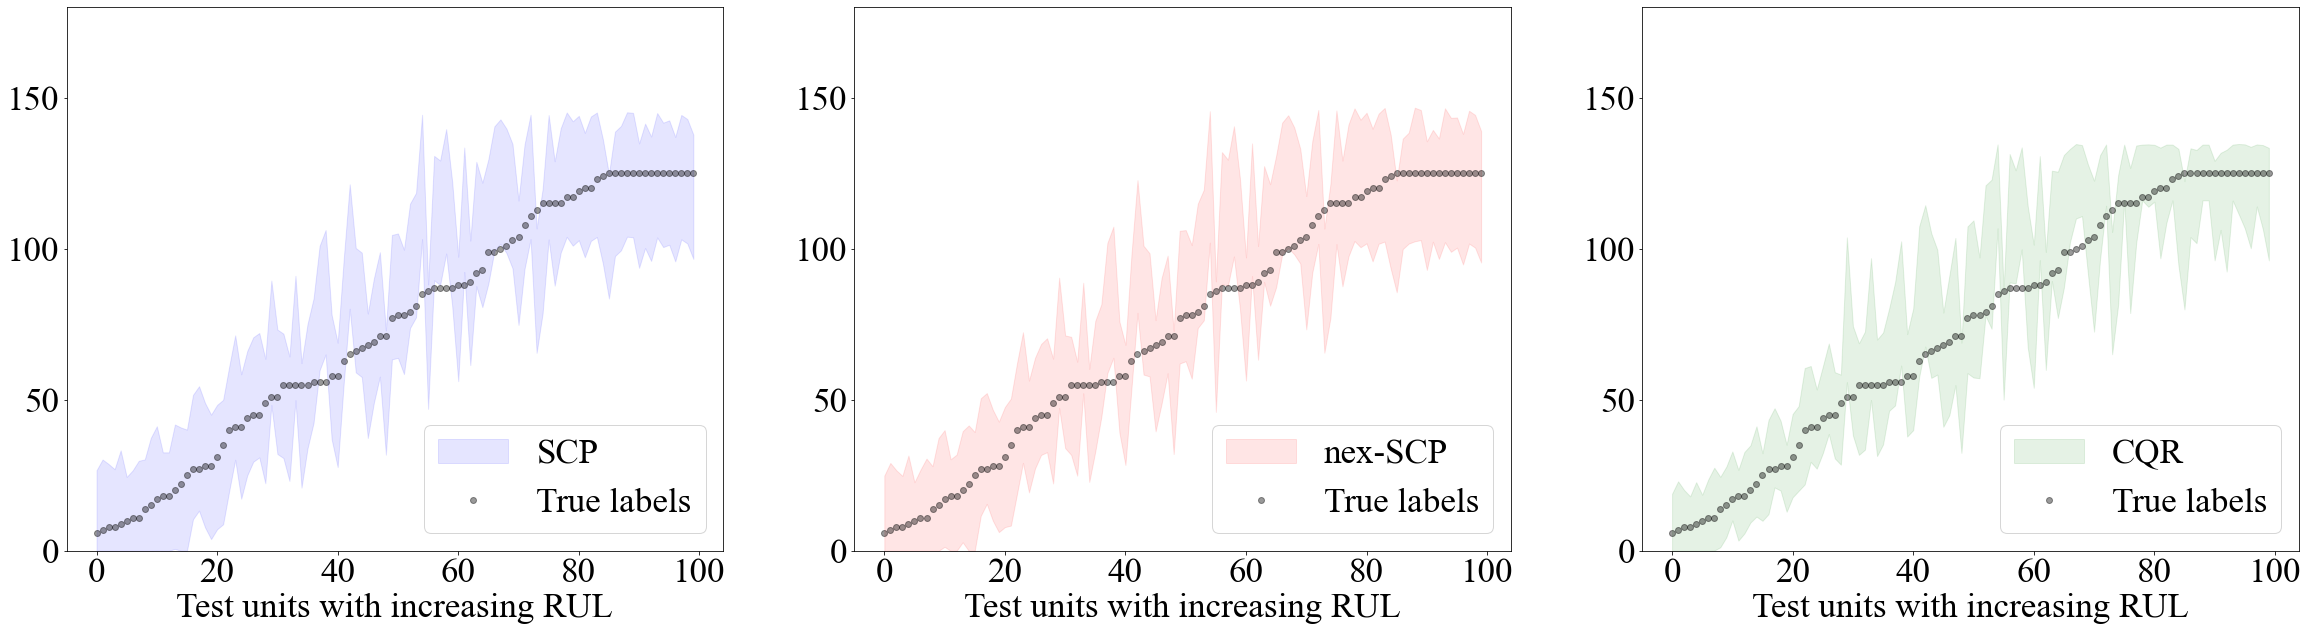

In [29]:
plot_sorted(exp, methods, y_test)

In [ ]:
import matplotlib

plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)
font = {'fontname':'Times New Roman'}
matplotlib.rc('font', **font)
plt.xlabel('average coverage')

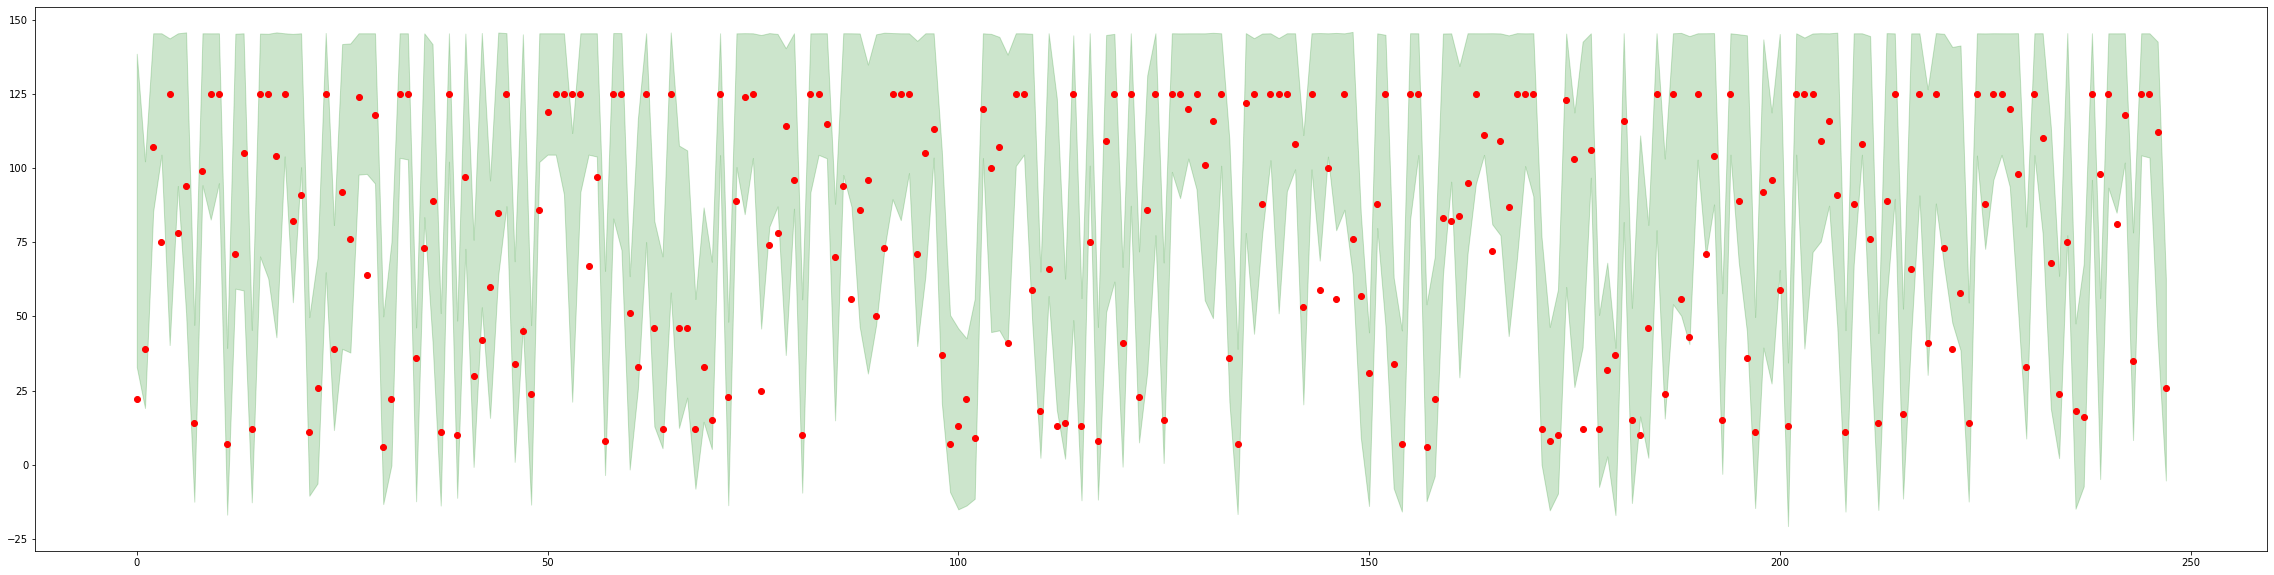

In [85]:
plt.figure(figsize=(40, 10))
y_low_CQR = y_hat_test_CQR[0] - q_CQR
y_high_CQR = y_hat_test_CQR[1] + q_CQR
plt.fill_between(range(len(y_hat_test_CQR[0])), y_low_CQR.reshape(-1), y_high_CQR.reshape(-1), color='green', alpha=0.2)
plt.plot(range(len(y_hat_test_CQR[0])), y_test, 'or')

In [105]:
sorted_y_idx = y_test.argsort(axis=0)
sorted_y = y_test[sorted_y_idx.reshape(-1)]
sorted_y

array([[  6.],
       [  6.],
       [  7.],
       [  7.],
       [  7.],
       [  7.],
       [  8.],
       [  8.],
       [  8.],
       [  9.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 11.],
       [ 11.],
       [ 11.],
       [ 11.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 13.],
       [ 13.],
       [ 13.],
       [ 13.],
       [ 14.],
       [ 14.],
       [ 14.],
       [ 14.],
       [ 15.],
       [ 15.],
       [ 15.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 18.],
       [ 22.],
       [ 22.],
       [ 22.],
       [ 22.],
       [ 23.],
       [ 23.],
       [ 24.],
       [ 24.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 26.],
       [ 30.],
       [ 31.],
       [ 32.],
       [ 33.],
       [ 33.],
       [ 33.],
       [ 34.],
       [ 34.],
       [ 35.],
       [ 36.],
       [ 36.],
       [ 36.],
       [ 37.],
       [ 37.],
       [ 3

In [107]:
sorted_y_low = y_low_CQR[sorted_y_idx.reshape(-1)]

sorted_y_low

array([[-12.26948   ],
       [-13.251315  ],
       [ -9.207292  ],
       [-16.616743  ],
       [-15.756405  ],
       [-16.811127  ],
       [-11.728525  ],
       [-15.361374  ],
       [ -3.4782906 ],
       [-11.460392  ],
       [-11.135793  ],
       [ -9.701668  ],
       [ 16.277931  ],
       [ -9.404545  ],
       [-13.738728  ],
       [-15.778656  ],
       [-14.597839  ],
       [-10.442679  ],
       [-12.6615715 ],
       [ 39.5233    ],
       [  0.13369751],
       [ -8.060177  ],
       [  5.5707283 ],
       [ -7.4631205 ],
       [ 18.374641  ],
       [-11.980366  ],
       [-20.6687    ],
       [-15.023525  ],
       [-15.228604  ],
       [  2.0397263 ],
       [-12.45227   ],
       [-12.3923025 ],
       [  0.5855713 ],
       [-12.889482  ],
       [ -3.0718193 ],
       [  5.3039665 ],
       [ -7.2999086 ],
       [-11.3939085 ],
       [-14.8085    ],
       [  2.347454  ],
       [ 32.90305   ],
       [ -0.15514374],
       [ -3.8498573 ],
       [-13

In [110]:
sorted_y_high = y_high_CQR[sorted_y_idx.reshape(-1)]

sorted_y_high

array([[138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],


In [113]:
sorted_y_idx.reshape(-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [117]:
sorted_y_idx = y_test.argsort()

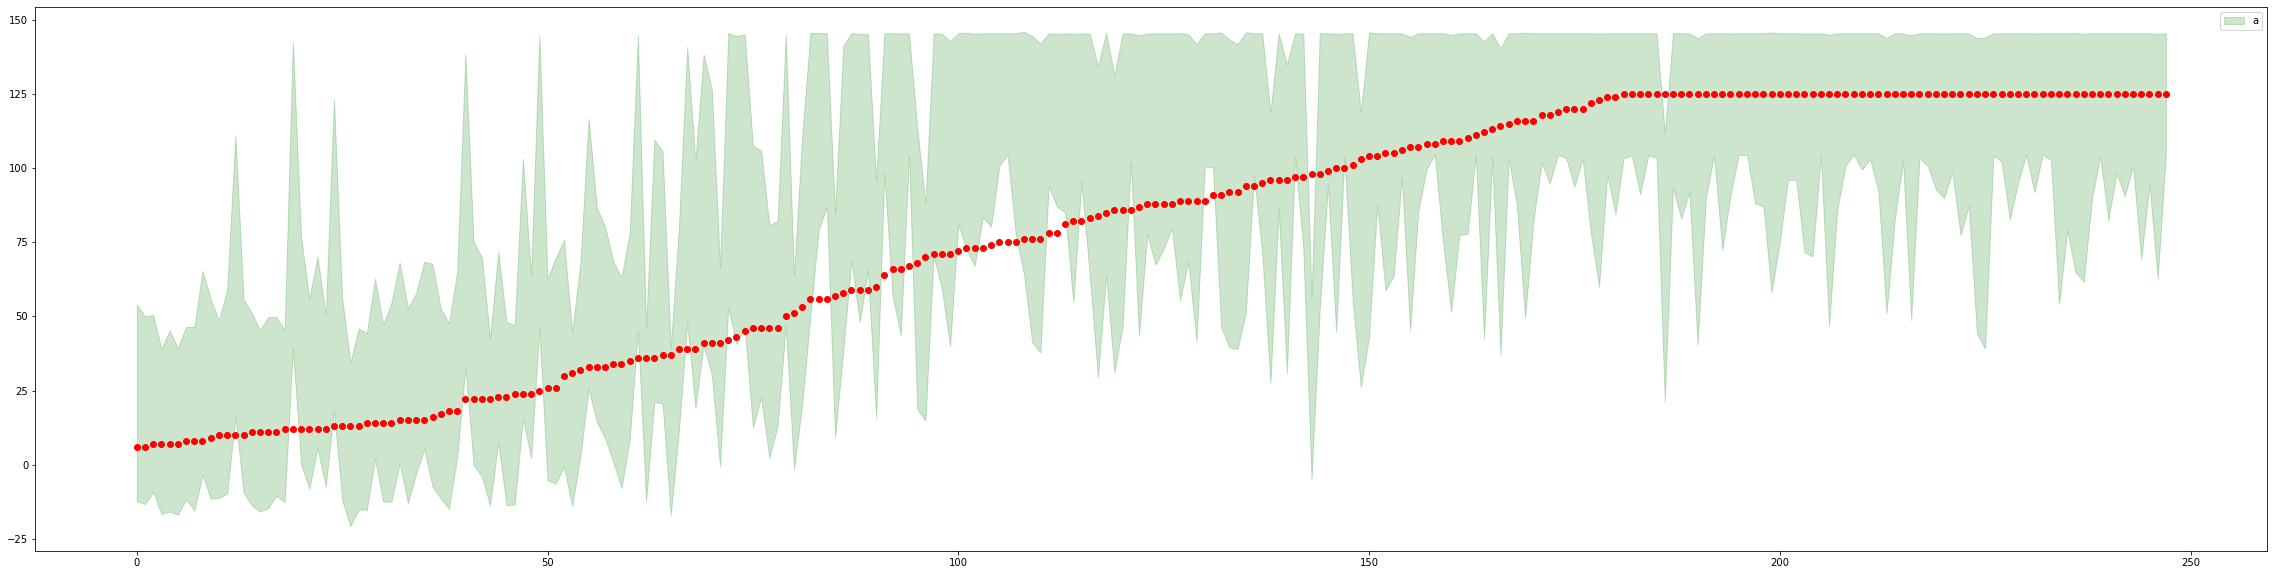

In [125]:
from cProfile import label


plt.figure(figsize=(40, 10))
sorted_y_idx = y_test.argsort(axis=0)
sorted_y = y_test[sorted_y_idx.reshape(-1)]
sorted_y_low = y_low_CQR[sorted_y_idx]
sorted_y_high = y_high_CQR[sorted_y_idx]
plt.fill_between(range(len(y_hat_test_CQR[0])), sorted_y_low.reshape(-1), sorted_y_high.reshape(-1), color='green', alpha=0.2, label='a')
plt.plot(range(len(y_hat_test_CQR[0])), sorted_y, 'or')
plt.legend()

In [164]:
y_hat_test_CQR[0].reshape(-1).shape

(37742,)

In [176]:
proc_dataset2["test"]["index"][proc_dataset2["test"]["id"]==50]

array([9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467,
       9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478,
       9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489,
       9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500,
       9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511,
       9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522,
       9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533,
       9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544,
       9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555,
       9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566,
       9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577,
       9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588,
       9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599,
       9600, 9601, 9602, 9603, 9604, 9605, 9606, 96

In [39]:
np.arange(50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [3]:
a.shape

(50,)

In [4]:
b = np.arange(70)

In [8]:
c = [a,b]
d = np.vstack(c)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 1 has size 70

In [9]:
d.shape

(120,)